# Lesson 8.2 CART分类树的建模流程与sklearn评估器参数详解

&emsp;&emsp;根据上一小节的介绍我们知道，CART树是目前机器学习领域内最通用的决策树，并且CART树能够同时解决分类问题和回归问题。本节我们将首先介绍关于CART树在进行分类问题建模时的基本流程，同时详细讲解sklearn中相关评估器的参数情况与使用方法。

In [1]:
# 科学计算模块
import numpy as np
import pandas as pd

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# 自定义模块
from ML_basic_function import *

# Scikit-Learn相关模块
# 评估器类
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# 实用函数
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 数据准备
from sklearn.datasets import load_iris

## 一、CART决策树的分类流程

&emsp;&emsp;从基本原理来说，决策是一种非常通用的模型，在模型训练时可以带入分类变量、也可以带入连续变量，同时在进行预测时既能解决分类问题也能解决回归问题，在介绍CART树的原理时，我们先从简单入手，先考虑自变量都是离散变量的分类预测问题，再逐步拓展连续变量的处理方法和回归类问题的预测方法。

### 1.CART树的基本生长过程

&emsp;&emsp;首先我们来看在特征都为分类变量时、围绕分类问题构建CART的基本过程。

#### 1.1 规则评估指标选取与设置

- 划分规则评估指标概念

&emsp;&emsp;在引言部分中我们曾简单构建了一个决策树，我们曾强调，决策树的建模过程实际上就是挖掘有效分类规律的过程，而这里的分类规律是否有效，其实是需要有一个评估标准的。此前我们是在逻辑回归的模型结论的基础上寻找分类规律，可以看成是根据分类结果的准确率来寻找分类规则，此时准确率就是评估分类条件好坏的评估指标，例如在决策树开始生长的第一层，我们选取petal length (cm) <= 2.5作为分类条件将原始数据集一分为二，分出来的两个数据集其中一个100%是一类数据，另一个则全是二、三类数据，此时如果我们根据准确率来判断该分类规则是否能够很好的区分一类和二、三类数据的话，那此时的准确率就是100%，此时的分类误差就是0。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsjsq3lmuhj31bo0kw40k.jpg" alt="1" style="zoom:30%;" /></center>

- 划分规则评估指标构建的核心思路

&emsp;&emsp;当然，这种定义分类评估指标的方法并不通用并且在多分类问题时容易引发混乱，例如如果是四分类问题，1条件能够100%区分A类和BCD类，2条件能够100%区分AB类和CD类，此时如何还按照准确率来进行判别分类条件好坏的判别一句，则选择哪个条件就成了问题。因此一般来说树模型挑选分类规则的评估指标并不是看每个类别划分后的准确率，而是父节点划分子节点后子节点数据集标签的纯度。

&emsp;&emsp;注意，此处纯度是一个非常重要的概念，一般来说如果一个数据集标签都比较倾向于取得同一个值（不管是都取0还是都取1），则我们就说这个数据集的标签纯度高，反之则说这个这个数据集标签纯度不高。而决策树的划分规则的评估标准，其实都是根据纯度来进行构建的。

> 其实，决策树生长的方向也就是令每个划分出来的子集纯度越来越高的方向。

- 单独一个数据集的标签纯度衡量指标

&emsp;&emsp;首先我们先来讨论对于一个单独的数据集来说，可以通过哪些指标来衡量该数据集标签的纯度。一般来说，用于衡量数据集标签纯度的数值指标一般有三种，分别是分类误差、信息熵和基尼系数，对于每个单独数据集来说，其基本计算公式如下：

(1)分类误差（Classification error）：        
$$
Classification\ error(t) = 1-\max_{1\leq i\leq c}[p(i|t)]
$$

&emsp;&emsp;其中i表示第i类，当前数据集总共有c类，$p(i|t)$代表第i类数据占当前数据集中总数据的比例。而所谓的分类误差，其实就是用1减去多数类的占比。例如某个包含10条数据的数据集，有6条0类数据、4条1类数据，此时该数据集分类误差就是1-6/10 = 0.4。分类误差在[0, 0.5]范围内取值，分类误差越小，说明数据集标签纯度越高。

> 此外，由于决策树中每一个数据集实际上就代表一系列分类规则，因此分类误差的另一种理解方法是，如果需要根据少数服从多数原则对当前数据集选取一个唯一的标签（此前一系列分类规则输出一个最终结果），则只能将所有少数类的标签改成多数类的标签，此时误差（对应的分类规则的误差）就是所有少数类的数据占比。

> 分类误差实际上就是贪心算法所使用的决策树划分规则评估指标

(2)信息熵（Entropy）：        
$$
Entropy(t) = -\sum_{i=1}^c p(i|t)log_2p(i|t)
$$

&emsp;&emsp;当然，我们此前所介绍的用于衡量数据混乱程度的信息熵也可以用于衡量数据集标签纯度，而信息熵的计算过程也正如此前介绍的一样：每个类别的数据占比乘以以2为底的对数处理结果，然后再进行不同类别的累加，最后进行负值处理。例如还是针对一个包含了6个0类、4个1类的数据集，信息熵计算结果为：

In [2]:
- 4/10 * np.log2(4/10) - 6/10 * np.log2(6/10)

0.9709505944546686

当然，回顾此前内容，信息熵也是在[0,1]之间取值，并且信息熵越小则说明数据集纯度越高。

> 信息熵的相关详细介绍参见Lesson 4.2

> ID3、C4.5、C5.0算法主要使用信息熵进行划分规则的挑选

(3)基尼系数（Gini）：        
$$
Gini(t) = 1-\sum_{i=1}^c p(i|t)^2
$$

&emsp;&emsp;此外，还有一个和信息熵的计算过程比较类似的评估指标——基尼系数。基尼系数通过计算1减去每个类别占比的平方和来作为纯度衡量指标，例如还是针对一个包含了6个0类、4个1类的数据集，基尼系数的计算结果为：

In [3]:
1 - np.power([4/10, 6/10], 2).sum()

0.48

而和信息熵不同的是，基尼系数在[0, 0.5]范围内取值，并且基尼系数越小表示数据集标签纯度越高

In [4]:
p_l = np.arange(0, 1, 0.01)

In [5]:
gini_l = []

for p in p_l:
    gini_l.append(1 - np.power([p, 1-p], 2).sum())

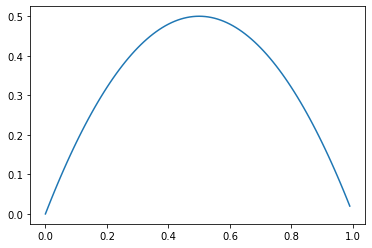

In [6]:
plt.plot(p_l, gini_l)

> 在默认情况下，CART树默认选择Gini系数作为评估指标。

&emsp;&emsp;在随后的建模试验中，我们也默认采用基尼系数作为评估指标。

&emsp;&emsp;当然我们也可以简单对比在二分类情况下三个评估指标伴随某类样本所占比例p值变化而变化的情况：

In [7]:
np.max([1, 2])

2

In [8]:
ce_l = []
gini_l = []
en_l = []

for p in p_l:
    ce_l.append(1-np.max([p, 1-p]))
    gini_l.append(1 - np.power([p, 1-p], 2).sum())
    en_l.append(entropy(p))

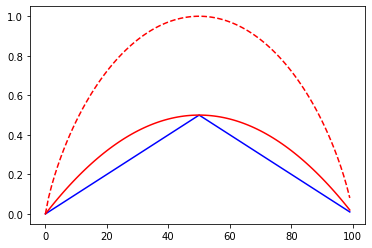

In [9]:
plt.plot(ce_l, 'b-', gini_l, 'r-', en_l, 'r--')

- 多个数据集的平均指标

&emsp;&emsp;在很多时候，我们不仅需要衡量单独数据集标签的纯度，我们还需要衡量多个数据集作为一个整体时的标签的纯度，例如一个父节点在划分成两个子节点时两个子节点整体的评估指标。此处我们举例说明：我们简化一组后续建模会用到的客户数据，简化后的数据集A共有两个特征、一个标签，并且标签只有0-1两个类别，数据集特征分别是收入（income）和信用评级（credit_rating），同样也都用有两个分类水平的离散变量表示。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsk5h2sslqj30ve0j4abf.jpg" alt="1" style="zoom:30%;" /></center>

此时我们首先可以计算该数据集整体的基尼系数：

In [10]:
p = 3/8
gini_A = 1 - np.power([p, 1-p], 2).sum()
gini_A

0.46875

然后我们随意设置一个分类条件。例如我们设置分类条件为income <= 1.5，则可以将上述数据集进一步划分成两个子数据集B1、B2:

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsk5o0g4kcj31h00u0adh.jpg" alt="1" style="zoom:30%;" /></center>

In [11]:
p = 2/5
gini_B1 = 1 - np.power([p, 1-p], 2).sum()
gini_B1

0.48

而B2数据集只包含一个标签，因此B2的基尼系数为0

In [12]:
gini_B2 = 0

而此时如果要计算B1、B2整体的基尼系数，则需要在gini_B1、gini_B2的基础上进行各自数据集样本数量占整体数据集比例的加权求和，即根据如下方式进行计算：

$$
Gini(B) = \frac{|B_1|}{|A|}Gini(B_1)+\frac{|B_2|}{|A|}Gini(B_2)
$$

其中$\frac{|B_i|}{|A|}$为子数据集$B_i$数据个数占父类数据集A中数据个数的比例。因此上述$B_1$、$B_2$整体基尼系数为：

In [13]:
gini_B = gini_B1 * 5/8 + gini_B2 * 3/8
gini_B

0.3

至此，我们就构建了一个用于描述数据集划分完后两个子集的整体纯度的方法，而我们知道，子集整体纯度越高，其实也就说明对应分类规则越有效。接下来我们将详细讨论如何构建分类规则以及如何对这些分类规则进行评估。

#### 1.2 决策树备选规则创建方法

&emsp;&emsp;正如此前所说，决策树模型的建模过程实际上就是在挑选有效分类规则的过程，而要挑选有效分类规则，首先就必须明确如何创建哪些备选规则，其实对于很多树模型，特征是离散型变量还是连续性变量会直接影响备选规则的创建，但对于CART树以及slearn中集成的方法来说，是将两种情况合二为一来进行看待，也就是根据如下方式来进行备选规则的创建：

&emsp;&emsp;对于任何特征矩阵，首先需要逐列对其进行数值排序，例如上述数据集A，我们可以单独提取income和credit_rating两列来进行降序排序，排序结果如下：

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsk7mc4px1j31ge040t91.jpg" alt="1" style="zoom:30%;" /></center>

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsk7mxh8p9j31gk03yq3b.jpg" alt="1" style="zoom:30%;" /></center>

&emsp;&emsp;据此，我们通过寻找这些特征不同取值之间的中间点作为切点，来构造备选规则。例如income有两个取值1、2，因此只有一个切点就是1.5，那么我们就能创造一个income <= 1.5的规则来对数据集进行划分，如此我们就能把income取值为1的数据划归一个子集、income取值为2的数据集划归另一个子集，实际上上面在介绍多数据集基尼系数计算过程时就是采用该规则。需要知道的是，在所构造的条件中不等号的方向实际上没有任何影响。当然，income只有两个取值只能找到一个切点只能构造一个规则，而credit_rating特征也有两个取值，因此也能找到一个切点构造一个备选规则，即我们其实也可以根据credit_rating <= 1.5来切分出两个子集。

&emsp;&emsp;而其实如果特征是三个取值的特征，则可以找到两个切点、找到两种划分数据集的方式。更进一步的，如果该数据中某特征是连续变量，每条不同的数据取值都不同，例如：

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsk7uq4dqcj31gq0400t4.jpg" alt="1" style="zoom:30%;" /></center>

则此时可以将其看成是拥有8个分类水平的分类变量，仍然还是寻找相邻取值水平的中间值作为切点来构造划分规则，此时由于age特征有8个不同的取值，因此可以构造7个备选的划分数据集的方法，例如age <= 36、age <= 34.5等等。也就是说，对于任何一个特征无论是连续型变量还是分类变量，只要有N个取值，就可以创造N-1个划分条件将原数据集划分成两份。

> 正是因为可以用一种方法就能同时处理连续变量和离散变量，因此在决策树建模的过程中我们无需特别区分两种类型特征的区别。

> 此外，需要注意的是，CART树用这种方法同时处理离散变量和连续变量，而C4.5只用这种方式处理连续变量（离散变量采用另一种方法），因此这里我们可以理解成是CART树将离散变量“连续化”，也就是将离散变量看成是连续变量，这也就是为何sklearn在说明文档中强调，sklearn的树模型无法处理分类变量的原因（原文：scikit-learn implementation does not support categorical variables for now.）。此处所谓的无法处理分类变量并不是不能带入分类变量进行建模，而是不支持类似C4.5的方法从离散特征中提取备选划分规则，而是会将离散变量也看成是连续变量，采用C4.5处理连续变量的方法处理离散变量。关于C4.5从离散特征中批量提取备选规则的方法我们会在课后阅读中介绍详细介绍。

> 实际上，机器学习不同统计算法，大多数时候都不会刻意区分特征的连续与离散。

#### 1.3 挑选最佳分类规则划分数据集

&emsp;&emsp;当然，对于上述A数据集，总共有两个特征，每个特征有一个备选划分规则，因此在对根结点划分时，其实是有两种数据集的划分方法，我们已经简单查看采用income <= 1.5进行分类的结果：

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsk5o0g4kcj31h00u0adh.jpg" alt="1" style="zoom:30%;" /></center>

而如果我们采用credit_rating <= 1.5来对数据集进行划分，则将出现下述结果：

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsk8hkbhh3j31bu0rcmzw.jpg" alt="1" style="zoom:30%;" /></center>

从结果上来看，这两个划分条件都能切分出一个只包含一类标签的数据集，结果区分不是很大，那么到底应该选用哪个分类规则对数据集进行第一次切分、让决策树完成第一步的生长呢？这个时候就要用到此前我们介绍的关于评价分类规则是否有效的评估指标了，一般来说对于多个规则，我们首先会计算父节点的基尼系数（Gini(A)），然后计算划分出的两个子节点整体基尼系数（Gini(B)），然后通过对比哪种划分方式能够让二者差值更大，即能够让子节点的基尼系数下降更快，我们就选用哪个规则。例如对上述例子，我们知道在以income <= 1.5为规则划分数据集时，基尼系数下降结果为：

In [14]:
gini_A - gini_B

0.16875

而如果采用第二个划分规则来进行数据集切分，则此时基尼系数下降结果为：

In [15]:
p = 3/4
gini_B2 = 1 - np.power([p, 1-p], 2).sum()
gini_B2

0.375

In [16]:
gini_B1 = 0

In [17]:
gini_B = gini_B1 * 1/2 + gini_B2 * 1/2
gini_B

0.1875

In [18]:
gini_A - gini_B

0.28125

很明显，第二个规则能够让父节点的基尼系数下降更快，因此第二个规则、即credit_rating <= 1.5划分规则是一个更好的规则，在第一次数据集划分时我们应该采用该规则。

> 注，如果是ID3或者C4.5，此处则是以信息熵计算结果为准。

#### 1.4 决策树的生长过程

&emsp;&emsp;当完成一次规则筛选与树生长后，接下来需要考虑的问题是，面对当前划分出的数据集B1、B2，是否还需要进一步寻找分类规则对其进行划分。

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsk8hkbhh3j31bu0rcmzw.jpg" alt="1" style="zoom:30%;" /></center>

&emsp;&emsp;首先，对于数据集B1来说，由于其基尼系数已经为0，无需再进行计算；而B2数据集基尼系数为0.375，还可以进一步提取有效分类规则对其进行分类，以降低其基尼系数。此时我们又可以完全重复数据集A的划分过程，首先围绕数据集B2进行备选规则的提取，对于B2来说备选规则只有income <= 1.5一条，因此我们就以该规则划分数据集：

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gsk98au1gjj31az0u0q6c.jpg" alt="1" style="zoom:30%;" /></center>

能够看出，最终划分出来的C1和C2基尼系数都是0，因此C的两个数据集整体基尼系数也是0，当然我们也无需进一步划分数据集，到此为止决策树也停止生长。

- 决策树生长与迭代运算

&emsp;&emsp;此前我们说到，决策树的生长过程本质上也是在进行迭代运算，我们根据上一轮的到的结论（数据集划分情况）作为基础条件，来寻找子数据集的最佳分类规则，然后来进行数据集划分，以此往复。既然是迭代运算，那就必然需要讨论所有迭代运算都需要考虑的两个问题，其一是每一轮的迭代目标、其二是迭代收敛条件。

&emsp;&emsp;首先是每一轮迭代计算的目标，在梯度下降的计算过程中，每一轮迭代其实都是为了能够更大程度上降低损失函数值，在K-Means快速聚类中，每一轮迭代其实都是为了能够尽快降低组内误差平方和（SSE），而在决策树的建模过程中，每一轮迭代实际上是为了更快速的降低基尼系数，也就是希望这一轮划分出来的子数据集纯度尽可能高，从而说明该规则会对分类更加有效。因此如果我们可以将每一轮迭代过程中父类的基尼系数看成是损失函数值，树的迭代生长过程就是为了能够更快速的降低父类的基尼系数值。

&emsp;&emsp;其次就是迭代计算的收敛条件。对于此前我们所介绍的收敛条件其实也同样适用于决策树模型，例如当两轮迭代损失函数的差值小于某个值、或者直接限制最大迭代次数，其实都是可以用于决策树模型的。此时所谓两轮迭代的损失值小于某个值就停止迭代，其实就等价于如果进一步的划分数据集、但基尼系数的减少少于某个值就暂时不做划分；而最大迭代次数其实就相当于树模型的最高生长层数，在实际建模过程中，我们也可以通过约束树最多生长几层来作为迭代收敛条件。当然，对于树模型来说，还有可能出现类似上述备选规则都用完了的情况，此时也会停止迭代。

### 2.CART树的剪枝

&emsp;&emsp;和逻辑回归不同，决策树在不进行特征衍生时就是一个分类效力更强的模型，因此其本身就是一个更容易过拟合的模型。并且通过观察我们不难发现，决策树生长的层数越多就表示树模型越复杂，此时模型结构风险就越高、模型越容易过拟合。因此，很多时候如果我们不对树的生长进行任何约束，即如果设置的收敛条件较为严格（例如要求最终基尼系数全为0），并且最大迭代次数不进行限制，则很有可能容易过拟合。因此在决策树的建模流程当中，有非常重要的一个环节，就是需要讨论限制决策树模型过拟合倾向的方法。

&emsp;&emsp;当然，不同决策树算法的剪枝策略也各有不同，总的来说树模型的剪枝分为两种，其一在模型生长前就限制模型生长，这种方法也被称为预剪枝或者盆栽法；而另外一种方法则是先让树模型尽可能的生长，然后再进行剪枝，这种方法也被称为后剪枝或者修建法。从算法的原生原理来讲，目前主流的C4.5和CART树都采用的是后剪枝的方法，其中C4.5是通过计算叶节点的期望错误率（一种区间估计的方法）来进行剪枝，而CART树则是通过类似正则化的方法在损失函数（基尼系数计算函数）中加入结构复杂度的惩罚因子，来进行剪枝。

&emsp;&emsp;不过，无论采用何种方式来进行剪枝，最终的结果都是通过控制树的结构复杂度来抑制过拟合倾向，而树模型的结构复杂度其实完全可以用树的层数、每一层分叉的节点数来表示，即内部节点和叶节点的数量来表示，因此我们也完全可以不采用这些树模型原生原理的方式来进行剪枝，而是直接将这些决定树模型的复杂度的因素视作超参数，然后通过网格搜索的方式来直接确定泛化能力最强的树模型结构。当然这也是sklearn中进行决策树剪枝的一般策略。

> 在sklearn 0.22版本之前，甚至没有支持CART树实现原生原理剪枝方式的参数。

## 二、CART分类树的Scikit-Learn快速实现方法与评估器参数详解

### 1.CART分类树的sklearn快速实现

&emsp;&emsp;接下来我们尝试在Scikit-Learn中构建分类树模型。在sklearn中，回归树和分类树是两个不同的评估器，都在sklearn.tree模块内，我们可以通过如下方式进行导入：

In [19]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor

然后尝试围绕上述简单例子进行快速建模试验：

In [38]:
# 准备数据集
X = np.array([[1, 1], [2, 2], [2, 1], [1, 2], [1, 1], [1, 2], [1, 2], [2, 1]])
y = np.array([0, 0, 0, 1, 0, 1, 1, 0])

In [39]:
# 调用决策树评估器并进行训练
clf = DecisionTreeClassifier().fit(X, y)

In [40]:
clf.score(X, y)

1.0

当然，对于树模型来说，我们不仅需要查看模型最终结果的评估指标，很多时候我们还希望能够观察到树模型分类过程的树状图，即类似于此前我们手动绘制的树状图。根据sklearn说明文档中的介绍，此处我们可以借助sklearn.tree模块下的plot_tree函数直接输入训练好的评估器即可进行绘制：

- plot_tree绘制树状图

In [41]:
# 首先导入tree模块
from sklearn import tree

[Text(279.0, 188.75, 'X[1] <= 1.5\ngini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(139.5, 113.25, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(418.5, 113.25, 'X[0] <= 1.5\ngini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(279.0, 37.75, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(558.0, 37.75, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]')]

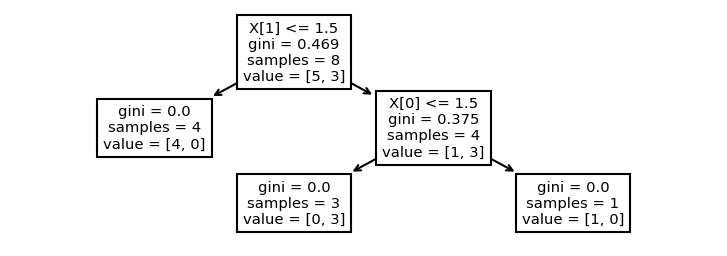

In [42]:
# 然后调用plot_tree函数进行绘制
plt.figure(figsize=(6, 2), dpi=150)
tree.plot_tree(clf)

&emsp;&emsp;由于plot_tree是sklearn中已经集成好的函数，因此调用过程非常简单，我们只需要输入训练好的分类树评估器即可。同时根据输出的结果可知，sklearn中分类树的建模过程和此前我们手动哦实现的过程是一样的，先根据第一个特征的不同取值进行数据集划分，然后在根据第二个特征的不同取值进行数据集划分，最终形成一个三个叶节点、两层的决策树模型。

&emsp;&emsp;当然，sklearn中的评估器使用过程基本一致，决策树模型评估器的简单使用也非常类似于逻辑回归评估器。此外，由于sklearn中优秀的参数默认值设置，使得很多时候我们直接使用其默认值就能完成不错的建模结果。接下来我们详细讨论决策树评估器中的相关参数，借此讨论关于sklearn中的决策树剪枝方法。

### 2.CART分类树评估器的参数详解

&emsp;&emsp;实际上DecisionTreeClassifier评估器参数众多，并且大多和决策树的模型结构相关：

In [25]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort='deprecated',
    ccp_alpha=0.0,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "entropy" for the information gain.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None
    The maximum depth of the tree. If None, then nodes

|Name|Description|      
|:--:|:--:| 
|criterion|规则评估指标或损失函数，默认基尼系数，可选信息熵| 
|splitter|树模型生长方式，默认以损失函数取值减少最快方式生长，可选随机根据某条件进行划分|
|max_depth|树的最大生长深度，类似max_iter，即总共迭代几次| 
|min_samples_split|内部节点再划分所需最小样本数| 
|min_samples_leaf|叶节点包含最少样本数| 
|min_weight_fraction_leaf|叶节点所需最小权重和| 
|max_features|在进行切分时候最多带入多少个特征进行划分规则挑选|
|random_state|随机数种子| 
|max_leaf_nodes|叶节点最大个数| 
|min_impurity_decrease|数据集再划分至少需要降低的损失值| 
|min_impurity_split|数据集再划分所需最低不纯度，将在0.25版本中移除| 
|class_weight|各类样本权重| 
|presort|已在0.24版本中移除| 
|ccp_alpha|在执行CART树原生原理中的剪枝流程时结构复杂度惩罚因子的系数，默认情况下不使用该方法进行剪枝| 

接下来围绕一些重点参数进行详细讲解：

- criterion：不纯度衡量指标

&emsp;&emsp;首先，我们发现尽管sklearn的树模型在默认情况下是CART树，但同样支持使用信息熵来衡量不纯度。不过需要注意的是，哪怕我们在criterion参数中选择信息熵，实际树模型的建模过程也不是按照ID3或者C4.5的流程执行，此时的树模型只能算是一种混合模型。而关于到底应该选择哪个指标来衡量数据集的不纯度，其实大多数情况下选择哪个指标并不会实质影响树模型的结构，但相比信息熵，基尼系数复杂度更低、计算速度更快，一般情况下推荐使用基尼系数。而如果一定要寻找二者在使用上的不同，一般认为在有些情况下，基尼不纯度更倾向于在数据集中分割出多数类，而信息熵则更倾向于生成出更加平衡的树。

- ccp_alpha：结构风险权重

&emsp;&emsp;ccp是复杂度剪枝（Cost-Complexity Pruning）的简称，这是一个在sklearn的0.22版本中才加入的参数，这也是唯一一个为实现CART原生原理中的剪枝过程所设置的参数。此处首先需要知道的是在sklearn中并不一定要通过该方法进行剪枝，因此该参数其实也并不是一个必选参数。其次，带有ccp项的剪枝也被称为最小复杂度剪枝，其原理是在决策树的损失函数上加上一个结构风险项，类似于正则化项在线性方程的损失函数中作用相同。        
&emsp;&emsp;我们可以设T为某决策树，$R(T)$为决策树在训练集上整体不纯度，即代表模型的经验风险，令$\alpha|\widetilde{T}|$表示模型结构风险，其中$\alpha$为参数，$|\widetilde{T}|$为树的叶节点数量，则我们可以修改模型损失函数如下：

$$
R_\alpha(T) = R(T) + \alpha|\widetilde{T}|
$$

&emsp;&emsp;其中$R_\alpha(T)$就是加入风险结构项后的损失函数，而$\alpha$则是风险结构项的系数。由此可知，$\alpha$取值越大、对模型的结构风险惩罚力度就越大、模型结构就越简单、过拟合就能够被更好的抑制，反之亦反。

- 控制树结构的参数类

&emsp;&emsp;接下来就是关于控制树模型结构的相关参数，同时这也是最多的一类参数。这类参数可以进一步细分成两类，其一是限制模型整体结构，主要包括限制树深度的max_depth参数和限制叶节点数量的max_leaf_nodes参数。此外第二类就是限制树生长的参数，包括从节点样本数量限制树生长的参数，包括min_samples_split、min_samples_leaf两个参数，当然也有从损失值降低角度出发限制树生长的参数，包括min_impurity_split和min_impurity_decrease参数。通过这些参数的共同作用，可以从各角度有效限制树的生长。

> 注意，所谓树的最大深度，指的是树的最多生长几层，或者除了根节点外总共有几层，并不是树的总共的层数。

&emsp;&emsp;此处需要重点说明的是，对于树模型来说，叶节点太多、单独叶节点所包含的样本数量太少、内部节点再划分降低的基尼系数较少，都是可能是过拟合的表现，在建模时尤其需要注意。

&emsp;&emsp;并且需要知道的是，sklearn中在计算父节点和子节点的基尼系数（或信息熵）的差值时，会在计算结果的前面乘以一个父节点占根节点数据量比例的系数作为最终impurity_decrease的结果：

<center><img src="https://tva1.sinaimg.cn/large/008i3skNly1gss9zte01aj30u20csmzb.jpg" alt="1" style="zoom:40%;" /></center>

而这会导致样本比较少的某节点，哪怕再划分时子节点纯度提升更高，但由于当前节点样本较少，因此impurity_decrease数值较低。这其实也是一种为了防止过拟合而采取的措施。

- 控制迭代随机过程的参数类

&emsp;&emsp;最后，还有一类参数值得注意，那就是关于控制建模过程中随机性的一些参数，主要包含两个，其一是splitter参数，当该参数取值为random时其实是随机挑选分类规则对当前数据集进行划分，其二是max_features，该参数可以任意设置最多带入几个特征进行备选规律挖掘，只要该参数的设置不是带入全部特征进行建模，就相当于是给备选特征随机划个范围，也相当于是给树模型的训练增加了一定的随机性。当然，这两个参数的主要作用有两个方面，其一是可以提升模型训练速度，试想一下，如果我们只从个别特征中挑选最佳划分规则，或者随机生成一个划分规则、不进行比较就直接使用，其实都能够极大节省计算量，只不过这也是一种用精度换效率的方式，如此操作肯定会带来模型结果精度的下降；不过随机性其实也是一把双刃剑，在集成学习中，为了让各基础分类器“和而不同”，就必须让每个基分类器保证一定的随机性，而决策树就是最常作为基分类器参与到集成学习中的模型，因此树模型中的这些控制其随机性的参数，也会在集成学习中发挥作用。

&emsp;&emsp;更多关于决策树的使用及各类参数的使用及调参方法，我们将在后续内容中进行详细介绍。